# Formula 1 Qualifying Comparison

In this script I will analyze the fastest qualifying laps at the pivotal race of the 2021 season, the Abu Dhabi GP.

The data in this analysis comes from the fastf1 package, which contains lots of F1 data. I am still familiarizing myself with this package, but I've figured out some basics.

### Setting Up

In [1]:
#Import necessary packages
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


In [2]:
#Enable the cache
ff1.Cache.enable_cache('C:/Users/jackh/OneDrive/Documents/Python Scripts/f1_cache') 

#Set up ff1 plotting
plotting.setup_mpl()

## Part I: Verstappen vs. Hamilton

The Abu Dhabi GP was the most important race of the season because it decided the championship between Verstappen & Hamilton. Our goal is to gain a little insight as to the parts of each driver's qualifying lap that made the difference, in which Verstappen ultimately won pole over Hamilton.
I'll start by downloading all the data for the qualifying session

In [3]:
#Get data
quali = ff1.get_session(2021, 'Abu Dhabi', 'Q')

#Get the laps
laps = quali.load_laps(with_telemetry=True)

core           INFO 	Loading laps for Abu Dhabi Grand Prix - Qualifying [v2.1.13]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['18', '44', '6', '47', '5', '16', '63', '55', '99', '33', '7', '22', '77', '4', '9', '31', '3', '11', '14', '10']


Now I can select all the laps that Verstappen & Hamilton drove in qualifying and choose their fastest

In [4]:
#Select all laps from Verstappen & Hamilton
laps_ver = laps.pick_driver('VER')
laps_ham = laps.pick_driver('HAM')

#Get their fastest data telemetry
fastest_ver = laps_ver.pick_fastest().get_telemetry().add_distance()
fastest_ham = laps_ham.pick_fastest().get_telemetry().add_distance()

#And add the driver variable
fastest_ver['Driver'] = 'VER'
fastest_ham['Driver'] = 'HAM'

#Finally, merge both telemetry objects into a single dataframe
telemetry = fastest_ver.append(fastest_ham)

telemetry.head()

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,DRS,Source,RelativeDistance,Status,X,Y,Z,Distance,Driver
2,2021-12-11 13:52:51.006,0 days 01:07:50.822000,,366.041667,0 days 00:00:00,11049,234,5,100,0,8,interpolation,0.000075,OnTrack,532,2076,-241,0.000000,VER
3,2021-12-11 13:52:51.029,0 days 01:07:50.845000,,366.041667,0 days 00:00:00.023000,11005,235,5,100,0,8,pos,0.000368,OnTrack,546,2077,-239,1.501389,VER
4,2021-12-11 13:52:51.036,0 days 01:07:50.852000,,366.041667,0 days 00:00:00.030000,10918,238,6,100,0,8,car,0.000458,OnTrack,550,2077,-238,1.964167,VER
5,2021-12-11 13:52:51.249,0 days 01:07:51.065000,,366.041667,0 days 00:00:00.243000,11070,240,6,100,0,8,pos,0.003206,OnTrack,692,2096,-239,16.164167,VER
6,2021-12-11 13:52:51.276,0 days 01:07:51.092000,11,366.041667,0 days 00:00:00.270000,11222,243,6,100,0,8,car,0.003559,OnTrack,710,2098,-239,17.986667,VER


### Creating minisectors for fastest lap analysis

Now that we have their lap times, we can break the laps down into 'minisectors,' or chunks. Let's divide the lap into 25 pieces.

For this section, I followed the lead of an interesting blog post that led me to discover the fastf1 package.
https://medium.com/towards-formula-1-analysis/analyzing-formula-1-data-using-python-2021-abu-dhabi-gp-minisector-comparison-3d72aa39e5e8 

In [5]:
#Define number of minisectors
num_minisectors = 25

#Get max distance on the track
total_distance = total_distance = max(telemetry['Distance'])

#Generate equally-sized mini-sectors
minisector_length = total_distance/num_minisectors

#Now we can find the point at which each minisector starts
minisectors = [0]

for i in range(0, (num_minisectors-1)):
    minisectors.append(minisector_length * (i+1))

#And we can figure out where in each minisector the car was at the moment the data point was recorded
telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda dist: (
        int((dist // minisector_length) + 1)
    )
)

In [6]:
telemetry.head()

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,DRS,Source,RelativeDistance,Status,X,Y,Z,Distance,Driver,Minisector
2,2021-12-11 13:52:51.006,0 days 01:07:50.822000,,366.041667,0 days 00:00:00,11049,234,5,100,0,8,interpolation,0.000075,OnTrack,532,2076,-241,0.000000,VER,1
3,2021-12-11 13:52:51.029,0 days 01:07:50.845000,,366.041667,0 days 00:00:00.023000,11005,235,5,100,0,8,pos,0.000368,OnTrack,546,2077,-239,1.501389,VER,1
4,2021-12-11 13:52:51.036,0 days 01:07:50.852000,,366.041667,0 days 00:00:00.030000,10918,238,6,100,0,8,car,0.000458,OnTrack,550,2077,-238,1.964167,VER,1
5,2021-12-11 13:52:51.249,0 days 01:07:51.065000,,366.041667,0 days 00:00:00.243000,11070,240,6,100,0,8,pos,0.003206,OnTrack,692,2096,-239,16.164167,VER,1
6,2021-12-11 13:52:51.276,0 days 01:07:51.092000,11,366.041667,0 days 00:00:00.270000,11222,243,6,100,0,8,car,0.003559,OnTrack,710,2098,-239,17.986667,VER,1


### Who was the fastest driver in each minisector?

Now we can analyze who was quickest in each minisector. I'll calculate Hamilton's average difference in speed to Verstappen across all 25 minisectors, and then calculate Verstappen's to Hamilton's.

In [7]:
#Calculate Hamilton gap
average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index().sort_values(by=['Minisector', 'Driver'], ascending = (True, False))
average_speed['ham_speed_gap'] = (average_speed.groupby(['Minisector'])['Speed'].apply(pd.Series.pct_change))

#Calculate Verstappen gaps
average_speed = average_speed.sort_values(by = ['Minisector', 'Driver'], ascending = (True))
average_speed['ver_speed_gap'] = (average_speed.groupby('Minisector')['Speed'].apply(pd.Series.pct_change))

#Combine & clean up
average_speed['gap'] = np.where(average_speed['ham_speed_gap'].isnull(),average_speed['ver_speed_gap'], average_speed['ham_speed_gap'])
average_speed = average_speed.drop(columns=['ham_speed_gap', 'ver_speed_gap'])


### Analyzing Speed of Each Minisector

One final piece of analysis I'll perform is to assign each minisector to 'low,' 'medium,' or 'high' speed depending on the average speed each driver achieved through the sector. This could tell us if one driver exceled at quicker or slower parts of the lap.

In [8]:
#Apply to dataframe
average_speed['Sector_speed'] = average_speed['Speed'].apply(lambda x: 'Low' if x < average_speed['Speed'].quantile(q=.33) else 'Medium' if x < average_speed['Speed'].quantile(q=.66) else 'High')


### Graph Results

Now we can graph the results. I gave plotnine a try here, as I like how it replicates the syntax of ggplot.

<ipython-input-9-4649af037fac>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


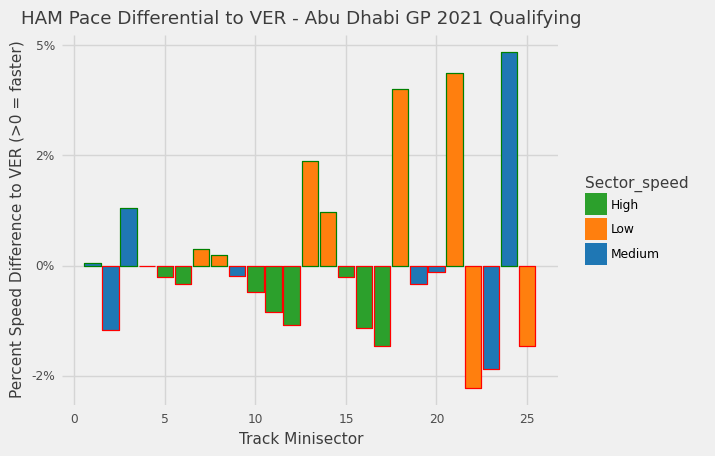

In [9]:
from plotnine import ggplot, coord_flip, aes, facet_wrap, geom_col, theme_538, scale_fill_manual, labs, ggtitle, guides, scale_y_continuous, scale_color_manual
#Create a dataset focusing on Hamilton
ham_gap = average_speed[average_speed['Driver']=='HAM']
#And add an indicator for if he was faster than Verstappen in this minisector
ham_gap['faster'] = ham_gap['gap'].apply(lambda x: 'true' if x <= 0 else 'false')

a = (ggplot(ham_gap)
     + geom_col(aes(x="Minisector", y = "gap", fill = "Sector_speed", color = 'faster'))
     + theme_538()
     + labs(x='Track Minisector', y = 'Percent Speed Difference to VER (>0 = faster)')
     + ggtitle('HAM Pace Differential to VER - Abu Dhabi GP 2021 Qualifying')
     + guides(color = False, size = False)
     + scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l])
     + scale_color_manual(values = ['green', 'red'])
     + scale_fill_manual(values = ['tab:green', 'tab:orange', 'tab:blue'])
)
print(a)


This chart reveals some interesting insight. You can see that Hamilton actually was considerably quicker than Verstappen for much of the lap, especially in the final low & medium speed sections of the track. However, in high-speed sections and a few low-speed ones, Verstappen was able to chain a few sections together to ultimately overcome Hamilton. The following visual drives home the speed differential over the lap

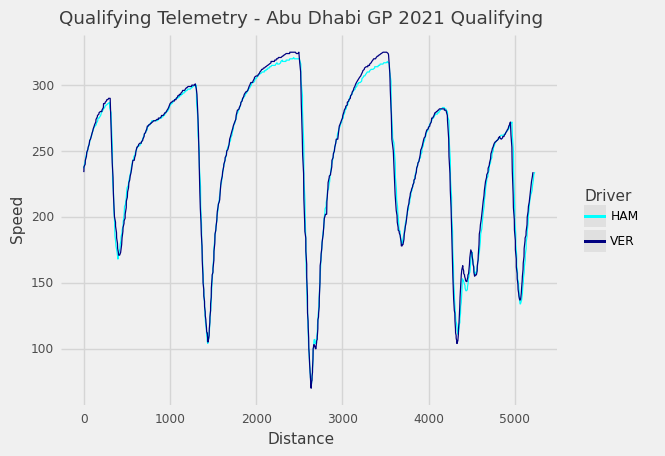

In [13]:
from plotnine import geom_line, scale_color_manual

telemetry_df = pd.DataFrame(telemetry)

b = (ggplot(telemetry_df, aes(x='Distance', y = 'Speed', color = 'Driver'))
     + geom_line()
     + theme_538()
     + labs(x='Distance', y='Speed')
     + ggtitle('Qualifying Telemetry - Abu Dhabi GP 2021 Qualifying')
     + scale_color_manual(['cyan', 'navy'])    
)

print(b)

You can see in this graph that Verstappen is able to consistently reach a higher speed than Hamilton before the heavy braking points; this likely made all the difference in the laptime.

## Part II: All Drivers Qualifying

We can replicate this analysis on a wider scale to look at every driver's performance during this qualifying session. The best comparison point for a driver is their teammate, so I'll compare each driver against his teammate for this session to get a quick & insightful view of which drivers outperformed or under-performed

#### Assembling the data

In [14]:
#Generate a driver & team list
driver_team = pd.DataFrame({'Driver':['VER', 'PER', 'HAM', 'BOT', 'LEC', 'SAI', 'RIC', 'NOR', 'ALO', 'OCO'
                                      , 'VET', 'STR', 'GAS', 'TSU', 'RUS', 'LAT', 'RAI', 'GIO', 'MSC', 'MAZ'],
                            'Team': ['Red Bull', 'Red Bull', 'Mercedes', 'Mercedes', 'Ferrari', 'Ferrari', 'McLaren', 'McLaren', 'Alpine', 'Alpine'
                                     , 'Aston Martin', 'Aston Martin', 'Alpha Tauri', 'Alpha Tauri', 'Williams', 'Williams', 'Alfa Romeo' , 'Alfa Romeo', 'Haas', 'Haas']})

driver_list = driver_team['Driver']
#Loop through that list to get data for all drivers
#Loop that grabs the fastest lap for every driver in this session
df = pd.DataFrame([])

for drv in driver_list:
    fastest = laps.pick_driver(drv).pick_fastest().get_telemetry().add_distance()
    #And add the driver variable
    fastest['Driver'] = drv
    fastest = pd.DataFrame(fastest)
    #Finally, merge both telemetry objects into a single dataframe
    df = df.append(fastest)
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14583 entries, 2 to 746
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   Date                   14583 non-null  datetime64[ns] 
 1   SessionTime            14583 non-null  timedelta64[ns]
 2   DriverAhead            14583 non-null  object         
 3   DistanceToDriverAhead  13858 non-null  float64        
 4   Time                   14583 non-null  timedelta64[ns]
 5   RPM                    14583 non-null  int64          
 6   Speed                  14583 non-null  int64          
 7   nGear                  14583 non-null  int64          
 8   Throttle               14583 non-null  int64          
 9   Brake                  14583 non-null  int64          
 10  DRS                    14583 non-null  int64          
 11  Source                 14583 non-null  object         
 12  RelativeDistance       14583 non-null  float64  

#### Minisector Assignment

In [15]:
#As before, generate minisector data and attach it to our main dataframe
num_minisectors = 25

#Get max distance on the track
total_distance = total_distance = max(df['Distance'])

#Generate equally-sized mini-sectors
minisector_length = total_distance/num_minisectors + .01
#Now we can find the point at which each minisector starts
minisectors = [0]

for i in range(0, (num_minisectors-1)):
    minisectors.append(minisector_length * (i+1))

df['Minisector'] = df['Distance'].apply(
    lambda dist: (
        int((dist // minisector_length) +1)
    )
)

#And add team data to the df
df = df.merge(driver_team, how = 'inner', on = 'Driver')

#### Calculate each driver's gap to their teammate

In [16]:
#First - create an object that ranks overall speed of each driver, so that we ensure each team's faster driver is the one that comes out ahead vs. his teammate (ie the gap in speed is always positive for the faster driver)
r = df.groupby(['Driver']).mean().reset_index()[["Driver", "Speed"]]
r['rank'] = r['Speed'].rank(ascending = False)
r = r.drop('Speed', axis = 1)
#And merge into the dataframe
df = df.merge(r, how = 'left', on = 'Driver')

#Calculate the faster driver's gap to their teammate
average_speed = df.groupby(['Minisector', 'Team', 'rank', 'Driver'])['Speed'].mean().reset_index().sort_values(by=['Team', 'Minisector', 'rank'], ascending = (True))


In [17]:
#Assign each minisector a speed category, as in Part I
#Except we assign speed based on all drivers' average speed through that minisector
sector_speed = df.groupby(['Minisector'])['Speed'].mean().reset_index()
sector_speed['Sector_speed'] = sector_speed['Speed'].apply(lambda x: 'Low' if x < sector_speed['Speed'].quantile(q=.33) else 'Medium' if x < sector_speed['Speed'].quantile(q=.66) else 'High')

sector_speed = sector_speed.drop('Speed', axis=1)

average_speed = average_speed.merge(sector_speed, how = 'left', on = 'Minisector')

#### And now we can look at each team's intra-team performance

In [18]:
#Calculate the faster driver's gap to their teammate
team_gap = average_speed.groupby(['Team', 'Driver'])['Speed'].mean().reset_index().sort_values(by = ['Team', 'Speed'], ascending = (True, False))
team_gap['gap_faster'] = (team_gap.groupby('Team')['Speed'].apply(pd.Series.pct_change))
#And the slower driver's gap
team_gap = team_gap.sort_values(by = ['Team', 'Speed'], ascending = (True))
team_gap['gap_slower'] = (team_gap.groupby('Team')['Speed'].apply(pd.Series.pct_change))

#And merge together
team_gap['speed_gap'] = np.where(team_gap['gap_faster'].isnull(), team_gap['gap_slower'], team_gap['gap_faster'])
team_gap = team_gap.drop(['gap_faster', 'gap_slower'], axis = 1).sort_values(by = 'speed_gap', ascending = False)

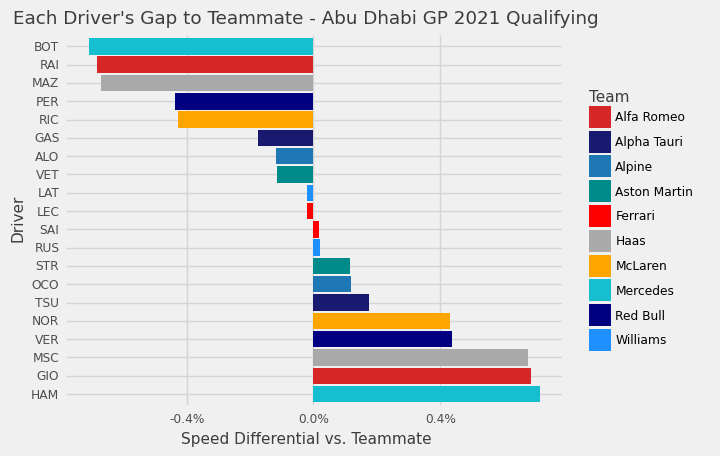

In [19]:
from plotnine import geom_col, theme_538, scale_fill_manual, labs, ggtitle, guides, scale_y_continuous, scale_color_manual, scale_fill_manual, coord_flip
from mizani.formatters import custom_format

team_gap['speed_gap_pct'] = team_gap['speed_gap']*100

driver_list = team_gap.sort_values(by = 'speed_gap', ascending = False)['Driver'].tolist()
driver_cat = pd.Categorical(team_gap['Driver'], categories = driver_list)

team_palette = {'Alfa Romeo':'tab:red', 'Alpha Tauri':'midnightblue', 'Alpine':'tab:blue', 'Aston Martin':'darkcyan', 'Ferrari':'red'
                , 'Haas': 'darkgrey', 'McLaren': 'orange', 'Mercedes':'tab:cyan', 'Red Bull':'navy', 'Williams':'dodgerblue'}
team_palette = pd.DataFrame.from_dict(team_palette, orient='index').reset_index()
team_palette.rename(columns={"index":"Team", 0:"Color"})

colors = team_palette[0].tolist()

a = (ggplot(team_gap, aes(x="driver_cat", y = "speed_gap_pct", fill = "Team"))
     + geom_col()
     + theme_538()
     + labs(x='Driver', y = 'Speed Differential vs. Teammate')
     + ggtitle("Each Driver's Gap to Teammate - Abu Dhabi GP 2021 Qualifying")
     + guides(color = False, size = False)
     + scale_y_continuous(labels=custom_format('{:.1f}%'))
     + coord_flip()
     + scale_fill_manual(values = colors)
)

print(a)

So there you have it. You can see that while Part I established that Verstappen beat Hamilton head-to-head, Hamilton actually beat his teammate Bottas (BOT) in a very convincing fashion during the session (there was talk of Bottas having issues with his engine during this session). Also of note here, we see that as per usual last year the Ferrari drivers were neck & neck while Mick Schumacher (MSC) handily defeated his teammate (MAZ) in qualifying.

This analysis was meant as an exercise for me to explore some new data and get familiar with Python functions. I hope you enjoyed!